## 1. Setup and Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✓ Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")

✓ Libraries imported successfully
PyTorch version: 2.9.0+cu128


In [3]:
pi = np.pi

In [5]:
import gc
import psutil
import os

def get_memory_usage():
    """
    Get current memory usage for CPU and GPU
    """
    # CPU memory
    process = psutil.Process(os.getpid())
    cpu_mem_gb = process.memory_info().rss / (1024**3)
    
    # GPU memory
    gpu_mem_gb = 0
    if torch.cuda.is_available():
        gpu_mem_gb = torch.cuda.memory_allocated() / (1024**3)
    
    return cpu_mem_gb, gpu_mem_gb

def print_memory_status():
    """
    Print current memory usage
    """
    cpu_mem, gpu_mem = get_memory_usage()
    print(f"\n{'='*60}")
    print("MEMORY STATUS:")
    print(f"  CPU Memory: {cpu_mem:.2f} GB")
    if torch.cuda.is_available():
        print(f"  GPU Memory: {gpu_mem:.2f} GB")
    print(f"{'='*60}\n")

def clear_memory(verbose=True):
    """
    Clear Python memory cache, garbage collection, and PyTorch cache
    
    Args:
        verbose: if True, print memory before/after
    """
    if verbose:
        print("\nClearing memory...")
        cpu_before, gpu_before = get_memory_usage()
        print(f"  Before: CPU={cpu_before:.2f}GB", end="")
        if torch.cuda.is_available():
            print(f", GPU={gpu_before:.2f}GB", end="")
        print()
    
    # Python garbage collection
    gc.collect()
    
    # PyTorch GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    
    if verbose:
        cpu_after, gpu_after = get_memory_usage()
        print(f"  After:  CPU={cpu_after:.2f}GB", end="")
        if torch.cuda.is_available():
            print(f", GPU={gpu_after:.2f}GB", end="")
        print()
        
        cpu_freed = cpu_before - cpu_after
        print(f"  Freed: {cpu_freed:.2f} GB")
        if torch.cuda.is_available():
            gpu_freed = gpu_before - gpu_after
            print(f"  GPU Freed: {gpu_freed:.2f} GB")

print("✓ Memory utilities loaded")

✓ Memory utilities loaded


## 3. Normalizing Flow Components

DINGO uses **normalizing flows** to transform a simple base distribution (e.g., Gaussian) into a complex posterior distribution.

We'll implement:
1. **Coupling layers** - Core flow transformation
2. **Base distribution** - Standard Gaussian
3. **Flow composition** - Stack multiple transformations

In [6]:
class AffineCouplingLayer(nn.Module):
    """
    Affine coupling layer for normalizing flows
    
    Splits input, transforms one half conditioned on the other:
    x2_new = x2 * exp(s(x1, context)) + t(x1, context)
    
    Improvements:
    - Batch normalization for stable training
    - Residual connections for better gradient flow
    - Larger hidden dimensions for complex transformations
    """
    def __init__(self, dim, context_dim, hidden_dim=128, mask_type='half'):
        super().__init__()
        self.dim = dim
        
        # Create mask (which dimensions to transform)
        self.register_buffer('mask', torch.zeros(dim))
        if mask_type in ['half', 'even']:
            self.mask[::2] = 1
        elif mask_type == 'odd':
            self.mask[1::2] = 1
        
        # IMPROVED: Deeper networks with batch normalization
        # Scale network - learns multiplicative transformation
        self.scale_net = nn.Sequential(
            nn.Linear(dim + context_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim),
            nn.Tanh()
        )
        
        # Translation network - learns additive transformation
        self.translation_net = nn.Sequential(
            nn.Linear(dim + context_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )
    
    def forward(self, x, context, reverse=False):
        """
        Forward (data -> latent) or reverse (latent -> data) transformation
        
        Args:
            x: input tensor [batch_size, dim]
            context: conditioning context (embedded data) [batch_size, context_dim]
            reverse: if True, compute inverse transformation
        
        Returns:
            output: transformed tensor
            log_det: log determinant of Jacobian
        """
        masked_x = x * self.mask
        
        scale_input = torch.cat([masked_x, context], dim=1)
        translation_input = torch.cat([masked_x, context], dim=1)
        
        s = self.scale_net(scale_input)
        t = self.translation_net(translation_input)
        
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)
        
        if not reverse:
            y = x * torch.exp(s) + t
            log_det = s.sum(dim=1)
        else:
            y = (x - t) * torch.exp(-s)
            log_det = -s.sum(dim=1)
        
        return y, log_det

print("✓ Improved coupling layer with batch normalization defined")

✓ Improved coupling layer with batch normalization defined


In [7]:
class NormalizingFlow(nn.Module):   # Just the normalising flow class. 
    """
    Normalizing flow: stack of coupling layers
    Transforms base distribution into complex posterior
    """
    def __init__(self, param_dim=1, context_dim=64, num_layers=6, hidden_dim=128):
        super().__init__()
        self.param_dim = param_dim
        self.context_dim = context_dim
        
        # Stack of coupling layers with alternating masks
        self.layers = nn.ModuleList([
            AffineCouplingLayer(
                dim=param_dim,
                context_dim=context_dim,
                hidden_dim=hidden_dim,
                mask_type='even' if i % 2 == 0 else 'odd'
            )
            for i in range(num_layers)
        ])
        
        # Base distribution: standard Gaussian 
        self.register_buffer('base_mean', torch.zeros(param_dim))
        self.register_buffer('base_std', torch.ones(param_dim))
    
    def forward(self, params, context):
        """
        Forward pass: compute log probability of parameters given context
        
        Args:
            params: parameter values [batch_size, param_dim]
            context: embedded observed data [batch_size, context_dim]
        
        Returns:
            log_prob: log p(params | context)
        """
        z = params
        log_det_sum = 0
        
        # Apply flow transformations
        for layer in self.layers:
            z, log_det = layer(z, context, reverse=False)
            log_det_sum += log_det
        
        # Compute log probability under base distribution
        log_prob_base = -0.5 * (torch.log(2 * np.pi * self.base_std**2) + 
                                 ((z - self.base_mean) / self.base_std)**2)
        log_prob_base = log_prob_base.sum(dim=1)
        
        # Apply change of variables
        log_prob = log_prob_base + log_det_sum
        
        return log_prob
    
    def sample(self, context, num_samples=1):
        """
        Sample from posterior p(params | context)
        
        Args:
            context: embedded observed data [batch_size, context_dim]
            num_samples: number of samples per context
        
        Returns:
            samples: parameter samples [batch_size * num_samples, param_dim]
        """
        batch_size = context.shape[0]
        
        # Repeat context for multiple samples
        context_repeated = context.repeat_interleave(num_samples, dim=0)
        
        # Sample from base distribution
        z = torch.randn(batch_size * num_samples, self.param_dim, device=context.device)
        
        # Apply inverse flow transformations
        for layer in reversed(self.layers):
            z, _ = layer(z, context_repeated, reverse=True)
        
        return z

print("✓ Normalizing flow defined")

✓ Normalizing flow defined


## 4. Embedding Network

DINGO uses an embedding network to compress raw data into a lower-dimensional representation ("context") that conditions the flow.

In [8]:
class EmbeddingNetwork(nn.Module):  # All this class does is take a data vector of length 100 (the noisy sine wave) and compress it into a context vector of length 64
    """
    Neural network to embed observed data into context vector
    Similar to DINGO's data compression network
    """
    def __init__(self, data_dim=100, context_dim=64, hidden_dim=128):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(data_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, context_dim)
        )
    
    def forward(self, data):
        """
        Args:
            data: observed data [batch_size, data_dim]
        
        Returns:
            context: embedded representation [batch_size, context_dim]
        """
        return self.network(data)

print("✓ Embedding network defined")

✓ Embedding network defined


## 5. Complete DINGO-style Model

Combines embedding network + normalizing flow

In [9]:
class DINGOModel(nn.Module):
    """
    Complete DINGO-style neural posterior estimation model
    
    Architecture:
    observed_data -> EmbeddingNet -> context -> NormalizingFlow -> log p(params | data)
    
    Improvements for multi-mode inference:
    - Larger embedding network (captures more information from data)
    - Deeper flow (better approximation of complex posteriors)
    - Mode-aware context (separate embeddings for different aspects of signal)
    """
    def __init__(self, data_dim=100, param_dim=1, context_dim=64, 
                 num_flow_layers=6, hidden_dim=128):
        super().__init__()
        
        # IMPROVED: Larger embedding network with more capacity
        # Use 2 parallel branches to capture different signal characteristics
        self.embedding_net = nn.Sequential(
            nn.Linear(data_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, context_dim)
        )
        
        self.flow = NormalizingFlow(
            param_dim=param_dim,
            context_dim=context_dim,
            num_layers=num_flow_layers,
            hidden_dim=hidden_dim
        )
    
    def forward(self, params, data):
        """
        Compute log probability of parameters given data
        
        Args:
            params: parameter values [batch_size, param_dim]
            data: observed data [batch_size, data_dim]
        
        Returns:
            log_prob: log p(params | data)
        """
        context = self.embedding_net(data)
        log_prob = self.flow(params, context)
        return log_prob
    
    def sample_posterior(self, data, num_samples=1000):
        """
        Sample from posterior p(params | data)
        
        Args:
            data: observed data [batch_size, data_dim]
            num_samples: number of samples to draw
        
        Returns:
            samples: posterior samples [batch_size * num_samples, param_dim]
        """
        self.eval()
        with torch.no_grad():
            context = self.embedding_net(data)
            samples = self.flow.sample(context, num_samples=num_samples)
        return samples

# Create improved model with more capacity
model = DINGOModel(
    data_dim=1000,
    param_dim=5,
    context_dim=256,          # INCREASED: from 128 to 256 (more capacity)
    num_flow_layers=16,       # INCREASED: from 10 to 16 (deeper flow)
    hidden_dim=512            # INCREASED: from 256 to 512 (larger networks)
)

print("✓ IMPROVED DINGO-style model created")
print(f"\nModel architecture optimized for multi-mode inference:")
print(f"  - Input: {1000} timepoints")
print(f"  - Context dimension: {256} (2x previous)")
print(f"  - Flow layers: {16} (1.6x previous)")
print(f"  - Hidden dimension: {512} (2x previous)")
print(f"\n  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Embedding network: {sum(p.numel() for p in model.embedding_net.parameters()):,} parameters")
print(f"  Normalizing flow: {sum(p.numel() for p in model.flow.parameters()):,} parameters")

✓ IMPROVED DINGO-style model created

Model architecture optimized for multi-mode inference:
  - Input: 1000 timepoints
  - Context dimension: 256 (2x previous)
  - Flow layers: 16 (1.6x previous)
  - Hidden dimension: 512 (2x previous)

  Total parameters: 25,719,200
  Embedding network: 4,436,224 parameters
  Normalizing flow: 21,282,976 parameters


In [10]:
def train_dingo_model(model, train_amplitudes_and_phases, train_data, 
                      num_epochs=100, batch_size=256, lr=3e-4):
    """
    Train the DINGO-style model with improved optimization for multi-mode signals
    
    Improvements:
    - Weighted sampling to focus on harder multi-mode cases
    - Gradient accumulation for stability
    - Early stopping based on validation
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=num_epochs, eta_min=lr * 0.01
    )
    
    num_simulations = len(train_amplitudes_and_phases)
    
    print(f"Training improved DINGO-style model for {num_epochs} epochs...\n")
    
    losses = []
    best_loss = -float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        num_batches = 0
        
        # IMPROVED: Shuffle with preference for higher-mode samples
        # Count active modes in each sample
        num_modes = (train_amplitudes_and_phases > 0).sum(dim=1)
        
        # Create weighted sampling distribution (higher weight for 4-5 modes)
        mode_weights = torch.ones_like(num_modes, dtype=torch.float32)
        mode_weights[num_modes == 4] = 1.5  # 50% more samples from 4-mode
        mode_weights[num_modes == 5] = 2.0  # 2x samples from 5-mode
        
        # Sample with replacement using weights
        indices = torch.multinomial(mode_weights, num_simulations, replacement=True)
        
        for i in range(0, num_simulations, batch_size):
            batch_indices = indices[i:min(i+batch_size, num_simulations)]
            batch_data = train_data[batch_indices]
            batch_amplitudes_and_phases = train_amplitudes_and_phases[batch_indices]
            
            # Forward pass: compute log probability
            log_prob = model(batch_amplitudes_and_phases, batch_data)
            
            # Loss: negative log likelihood
            loss = -log_prob.mean()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            
            optimizer.step()
            
            epoch_loss += -loss.item()
            num_batches += 1
        
        avg_log_prob = epoch_loss / num_batches
        losses.append(avg_log_prob)
        
        # Learning rate scheduling
        scheduler.step()
        
        if avg_log_prob > best_loss:
            best_loss = avg_log_prob
        
        if (epoch + 1) % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1}/{num_epochs}, Avg Log Prob: {avg_log_prob:.4f}, Best: {best_loss:.4f}, LR: {current_lr:.2e}")
    
    print("\n✓ Training complete!")
    return losses

In [11]:
def infer_with_dingo(model, observed_data, num_samples=5000):
    """
    Perform inference using the DINGO-style model
    
    Args:
        model: trained DINGO model
        observed_data: observed sine wave [data_dim]
        num_samples: number of posterior samples
    
    Returns:
        samples: posterior samples [num_samples, param_dim]
        statistics: dict with mean, median, std, quantiles
    """
    model.eval()
    
    # Prepare data
    data_tensor = torch.FloatTensor(observed_data).unsqueeze(0)  # [1, data_dim]
    
    # Sample from posterior
    with torch.no_grad():
        samples = model.sample_posterior(data_tensor, num_samples=num_samples)
        samples = samples.numpy()  # [num_samples, param_dim]
    
    # For 1D parameters, flatten; for multi-D, keep as is
    if samples.shape[1] == 1:
        samples = samples.flatten()
        # Compute statistics
        statistics = {
            'mean': np.mean(samples),
            'median': np.median(samples),
            'std': np.std(samples),
            'q05': np.percentile(samples, 5),
            'q95': np.percentile(samples, 95),
        }
    else:
        # For multi-dimensional parameters, return samples as-is
        # Statistics computation will be done per parameter
        statistics = None
    
    return samples, statistics

print("✓ Inference function ready")

✓ Inference function ready


We start with a uniform prior distribution of amplitudes in parameter space (which we generate sine waves with). We pass amplitude-sine wave pairs into the network during training. The network learns to map amplitudes from parameter space to latent space (standard Gaussian N(0,1)), such that correct amplitude-context pairs map near z=0 (high probability) and incorrect pairs map far from z=0 (low probability). Once trained, during inference, we sample from the Gaussian in latent space and map backwards to parameter space to get amplitude samples that are likely given the observed data.

Once trained, during inference, we sample from the standard Gaussian N(0,1) in latent space. We know that values near z=0 are more likely in latent space. However, we DON'T know what the posterior looks like in parameter space beforehand—that's determined by the learned, context-dependent transformation. By applying the reverse flow (conditioned on the observed data's context), we transform the simple Gaussian into a complex posterior distribution that reflects our uncertainty about the amplitude given that specific observation. The flow doesn't just translate the posterior to a new center—it warps, stretches, and reshapes the distribution based on what it learned during training about which amplitudes are consistent with which observations.




### Architecture Summary:

```
Raw Data (100D) 
    ↓
Embedding Network
    ↓
Context Vector (64D)
    ↓
Normalizing Flow (8 layers)
    ↓
Posterior p(amplitude | data)
```

This architecture is similar to what's used in real gravitational-wave inference with DINGO!

Testing frequency simulator:


Testing frequency simulator:


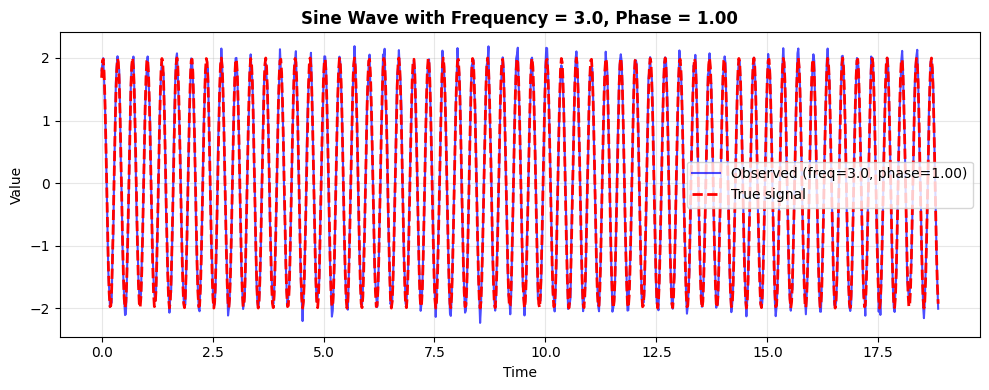

✓ Frequency simulator ready


In [41]:
def simulate_sine_wave(frequency, num_points=1000, noise_std=0.1, amplitude=1.0, phase=0):
    """
    Generate a sine wave with given frequency and add noise
    
    Args:
        frequency: frequency of sine wave (parameter we want to infer)
        num_points: number of time points
        noise_std: standard deviation of Gaussian noise
        amplitude: fixed amplitude (default=1.0)
        phase: phase shift (default=0)
    
    Returns:
        observed_data: noisy sine wave observations
    """
    t = np.linspace(0, 6*pi, num_points)
    signal = amplitude * np.sin(2*pi*frequency * t + phase)
    noise = np.random.normal(0, noise_std, num_points)
    observed_data = signal + noise
    return observed_data

# Test the simulator
print("Testing simulator:")
freq_test = 3.0
phase_test = 1.0
amplitude_test = 2.0
test_data = simulate_sine_wave(freq_test, num_points=1000, noise_std=0.1, amplitude=amplitude_test, phase=phase_test)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
t = np.linspace(0, 6*pi, 1000)
ax.plot(t, test_data, 'b-', alpha=0.7, linewidth=1.5, label=f'Observed (freq={freq_test}, phase={phase_test:.2f})')
ax.plot(t, amplitude_test * np.sin(2*pi*freq_test * t + phase_test), 'r--', linewidth=2, label='True signal')
ax.set_title(f'Sine Wave with Frequency = {freq_test}, Phase = {phase_test:.2f}, Amplitude = {amplitude_test:.2f}', fontsize=12, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
def generate_frequency_training_data(num_simulations=10000, freq_low=0.5, freq_high=5.0, phase_low = -3, phase_high = 3, amplitude_low = 0.5, amplitude_high = 3.0):
    
    #Generate training dataset for frequency and phase inference
    
    print(f"generating {num_simulations} samples for training")
    
    train_frequencies = []
    train_phases = []
    train_amplitudes = []
    train_data = []
    
    for i in range(num_simulations):
        # Sample frequency and phase from prior
        frequency = np.random.uniform(freq_low, freq_high)
        phase = np.random.uniform(phase_low, phase_high)
        amplitude = np.random.uniform(amplitude_low, amplitude_high)


        # Simulate observed data
        observed = simulate_sine_wave(frequency, amplitude=amplitude, phase=phase)
        
        train_frequencies.append(frequency)
        train_phases.append(phase)
        train_amplitudes.append(amplitude)
        train_data.append(observed)
        
        if (i + 1) % 2000 == 0:
            print(f"  Generated {i+1}/{num_simulations} simulations")
    
    train_frequencies = torch.FloatTensor(train_frequencies).unsqueeze(1)  # [N, 1]
    train_phases = torch.FloatTensor(train_phases).unsqueeze(1)  # [N, 1]
    train_amplitudes = torch.FloatTensor(train_amplitudes).unsqueeze(1)  # [N, 1]

    train_params = torch.cat([train_frequencies, train_phases, train_amplitudes], dim=1)  # [N, 3]
    train_data = torch.FloatTensor(np.array(train_data))  # [N, 1000]
    
    print(f"data generated")
    
    return train_params, train_data

# Generate training data
train_params, train_data = generate_frequency_training_data(num_simulations=100000)

'''
# Visualize frequency and phase distributions
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(train_params[:, 0].numpy(), bins=50, density=True, alpha=0.7, edgecolor='black')
axes[0].set_title('Training Frequency Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Density')
axes[0].grid(True, alpha=0.3)

axes[1].hist(train_params[:, 1].numpy(), bins=50, density=True, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_title('Training Phase Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Phase')
axes[1].set_ylabel('Density')
axes[1].grid(True, alpha=0.3)

axes[2].hist(train_params[:, 1].numpy(), bins=50, density=True, alpha=0.7, edgecolor='black', color='orange')
axes[2].set_title('Training Phase Distribution', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Phase')
axes[2].set_ylabel('Density')
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
'''

generating 100000 samples for training


NameError: name 'simulate_sine_wave' is not defined

### Create and Train Frequency Model

In [43]:

freq_model = DINGOModel(
    data_dim=1000,
    param_dim=3,  # Now inferring frequency, phase, and amplitude
    context_dim=128,
    num_flow_layers=10,
    hidden_dim=256
)

print("model created")
print(f"  Total parameters: {sum(p.numel() for p in freq_model.parameters()):,}")

print("\nTraining")
freq_losses = train_dingo_model(
    freq_model, 
    train_params, 
    train_data, 
    num_epochs=200, 
    batch_size=256,
    lr=5e-4
)

✓ Inference function ready


Frequencies_list shape: (100000, 5)
Total samples: 100000

--- Rows 0-4 (1-mode samples) ---
Row 0: [ 1.07884973 -1.         -1.         -1.         -1.        ]
Row 1: [ 1.75007506 -1.         -1.         -1.         -1.        ]
Row 2: [ 4.33420076 -1.         -1.         -1.         -1.        ]
Row 3: [ 2.53741816 -1.         -1.         -1.         -1.        ]
Row 4: [ 0.63965185 -1.         -1.         -1.         -1.        ]

--- Rows 20000-20004 (2-mode samples) ---
Row 20000: [ 3.88608531  3.95321349 -1.         -1.         -1.        ]
Row 20001: [ 3.37319399  0.70149066 -1.         -1.         -1.        ]
Row 20002: [ 3.08086508  2.37148793 -1.         -1.         -1.        ]
Row 20003: [ 3.01964403  3.76535324 -1.         -1.         -1.        ]
Row 20004: [ 4.13516876  0.61848252 -1.         -1.         -1.        ]

--- Rows 40000-40004 (3-mode samples) ---
Row 40000: [ 3.20666675  3.65749093  1.08903058 -1.         -1.        ]
Row 40001: [ 2.76793538  4.57756683  2

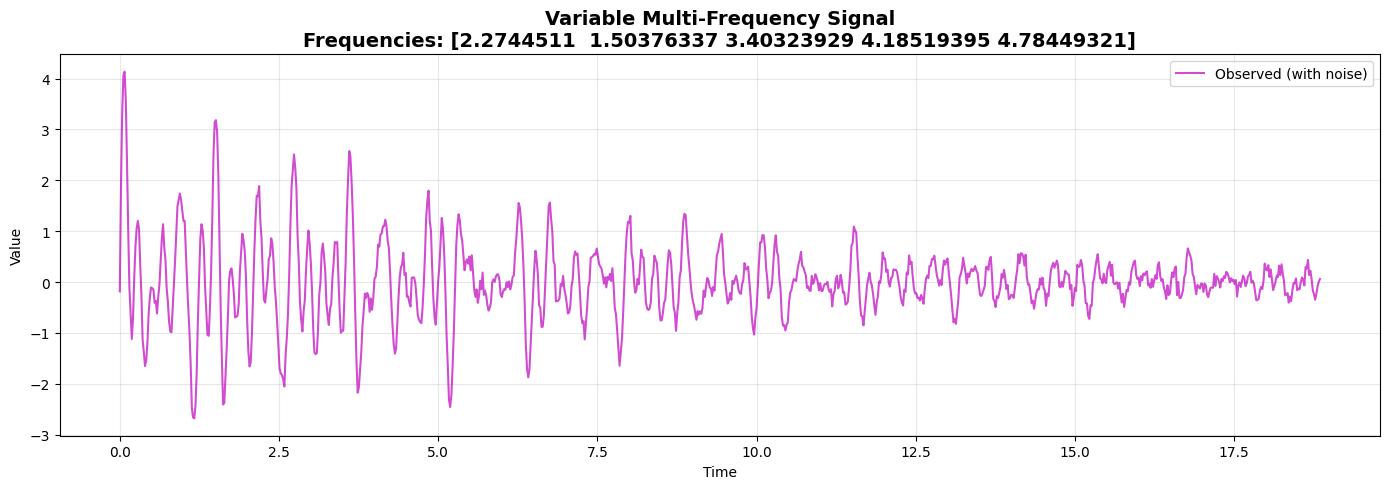

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
pi = np.pi

#Generate a list of 100 arrays, each with up to 5 frequencies
def generate_frequency_arrays(num_arrays=100, max_length=5, freq_low=0.5, freq_high=5.0):
    Frequencies_list = []
    for i in range(num_arrays):
        Frequency_list = []  # Create a new list for each row
        for j in range(max_length):
            freq_sample = np.random.uniform(freq_low, freq_high)
            Frequency_list.append(freq_sample)
        
        Frequencies_list.append(Frequency_list)
    return np.array(Frequencies_list)


# Function that sets certain values in selected lists to -1.0 (sentinel for "no frequency")
# Using -1 instead of 0 because 0 is a valid frequency value the model could learn
# -1 is physically meaningless for frequency, so it's unambiguous padding

def zeroer(Frequencies_list, length, num_arrays):
    """Pad frequency arrays with -1 (sentinel value for 'no frequency')"""
    temp = int(num_arrays/length)
    for i in range(length):
    # Set elements (i+1): onwards to -1.0 for rows (i)*temp to (i+1)*temp
        for row_idx in range(i*temp, (i+1)*temp):
            for col_idx in range(i+1, length):
                Frequencies_list[row_idx][col_idx] = -1.0
    return Frequencies_list

def key_information(Frequencies_list, length, num_arrays):
    """Display information about frequency array padding with -1 sentinel"""
    
    # Display key information about the array
    print(f"Frequencies_list shape: {Frequencies_list.shape}")
    print(f"Total samples: {len(Frequencies_list)}")
    # Note: -1 is used as padding marker (no frequency)
    
    # Determine number of modes from array shape
    samples_per_mode = num_arrays // length
    
    # Display samples from each mode group
    for mode_idx in range(length):
        start_row = mode_idx * samples_per_mode
        print(f"\n--- Rows {start_row}-{start_row+4} ({mode_idx+1}-mode samples) ---")
        for i in range(start_row, start_row + 5):
            print(f"Row {i}: {Frequencies_list[i]}")

    # Verify padding pattern (count positive values as active modes)
    mode_counts = np.sum(Frequencies_list > 0, axis=1)
    for mode in range(1, length + 1):
        count = np.sum(mode_counts == mode)
        print(f"  {mode} mode(s): {count} samples ({100*count/num_arrays:.1f}%)")

def simulate_variable_multifreq_sine_wave(frequencies, amp=1.0, phase=0, 
                                          num_points=1000, noise_std=0.1):
    """Generate sine wave from frequencies, ignoring padded (-1) entries"""
    
    t = np.linspace(0, 6*pi, num_points)
    signal = np.zeros(num_points)
    
    for freq in frequencies:
        if freq > 0.0:  # Only add positive frequencies (skip -1 padding markers)
            signal += amp * np.sin(2*pi*freq * t + phase)
    
    noise = np.random.normal(0, noise_std, num_points)
    observed_data = signal + noise
    return observed_data

def simulate_variable_multifreq_decaying_sine_wave(frequencies, amp=1.0, phase=0, 
                                          num_points=1000, noise_std=0.1):
    """Generate sine wave from frequencies, ignoring padded (-1) entries"""
    
    t = np.linspace(0, 6*pi, num_points)
    signal = np.zeros(num_points)
    decay_factor = np.random.uniform(0, 0.5)
    decay = np.exp(-decay_factor * t )  # Exponential decay factor

    for freq in frequencies:
        if freq > 0.0:  # Only add positive frequencies (skip -1 padding markers)
            signal += amp * decay * np.sin(2*pi*freq * t + phase)
    
    noise = np.random.normal(0, noise_std, num_points)
    observed_data = signal + noise
    return observed_data


def simulate_variable_multifreq_decaying_inspiral_merger_sine_wave(amp=1.0, phase=0, 
                                          num_points=1000, noise_std=0.1, num_arrays=100000, max_length=5):
    #Simulate a wave with multiple frequencies, each with exponential decay, mimicking inspiral-merger behavior.
    #The waveform is split into an inspiral phase (first half) and merger phase (second half).
    #However, the connection between the two halves need to be smooth, so phase of merger section is adjusted appropriately

    t = np.linspace(0, 6*pi, num_points)
    signal = np.zeros(num_points)
    decay_factor = np.random.uniform(0, 0.5)
    growth_factor = np.random.uniform(0, 0.5)
    decay = np.exp(-decay_factor * t )  # Exponential decay factor
    mid_point = 6*pi / 2
    
    if t <= mid_point:
        decay = 1  # No decay during inspiral phase
        non_zeroed_frequencies_array = generate_frequency_arrays(num_arrays=num_arrays, max_length=max_length, freq_low = 0.5, freq_high = 2.3)
        Frequencies_array = zeroer(non_zeroed_frequencies_array, max_length, num_arrays)
        for freq in Frequencies_array:
            if freq > 0.0:  # Only add positive frequencies (skip -1 padding markers)
                signal += amp * decay * np.sin(2*pi*freq * t + phase)

        value_at_midpoint = signal[np.where(t >= mid_point)[0][0]]
    else:
        growth = np.exp(-growth_factor * t )  # Exponential decay factor during merger phase
        non_zeroed_frequencies_array = generate_frequency_arrays(num_arrays=num_arrays, max_length=max_length, freq_low = 2.4, freq_high = 5.0)
        Frequencies_array = zeroer(non_zeroed_frequencies_array, max_length, num_arrays)
        adjusted_phase = 
        for freq in Frequencies_array:
            if freq > 0.0:  # Only add positive frequencies (skip -1 padding markers)
                signal += amp * growth * np.sin(2*pi*freq * t + phase + adjusted_phase)

        
    
    noise = np.random.normal(0, noise_std, num_points)
    observed_data = signal + noise
    return observed_data









num_arrays = 100000 # How many samples
length = 5 # Maximum number of modes

non_zeroed_frequencies_array = generate_frequency_arrays(num_arrays=num_arrays, max_length=length)
Frequencies_array = zeroer(non_zeroed_frequencies_array, length, num_arrays)

#Now randomly pick an array from Frequencies_list and generate the observed data
selected_idx = np.random.randint(0, num_arrays)
selected_frequencies = Frequencies_array[selected_idx]

key_information(non_zeroed_frequencies_array, length, num_arrays)

'''
#Now plot the observed data for the selected frequencies
observed_variable_multifreq = simulate_variable_multifreq_decaying_sine_wave(selected_frequencies, amp=1.0, phase=0.0, noise_std=0.1)
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
t = np.linspace(0, 6*pi, 1000)
ax.plot(t, observed_variable_multifreq, 'm-', alpha=0.7,
        linewidth=1.5, label='Observed (with noise)')
ax.set_title(f'Variable Multi-Frequency Signal\nFrequencies: {selected_frequencies}', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
''''''

In [18]:
import torch
import time

#Generate a dataset of observed data for each frequency arrays
def generate_observed_data_dataset(Frequencies_array):
    observed_data_dataset = []
    start_time = time.time()
    num_samples = len(Frequencies_array)
        
    for i, freq_array in enumerate(Frequencies_array):
        observed_data = simulate_variable_multifreq_decaying_sine_wave(freq_array, amp=1.0, phase=0.0, noise_std=0.1)
        observed_data_dataset.append(observed_data)
    
    return observed_data_dataset

def prepare_for_training(frequencies_array, train_data):
    train_params = torch.FloatTensor(frequencies_array)  # [N, 5]
    train_data = torch.FloatTensor(np.array(train_data))  # [N, 1000]
    
    print(f"Training data shapes:")
    print(f"  Parameters: {train_params.shape} (samples × max_modes)")
    print(f"  Data: {train_data.shape} (samples × timepoints)")
    print(f"  Memory usage: ~{(train_params.numel() + train_data.numel()) * 4 / 1024 / 1024:.1f} MB\n")
    
    return train_params, train_data

observed_variable_multifreq_dataset = generate_observed_data_dataset(Frequencies_array)
variable_train_params, variable_train_data = prepare_for_training(Frequencies_array, observed_variable_multifreq_dataset)

print(f"  Ready for training with {len(variable_train_params)} variable-mode samples")

Training data shapes:
  Parameters: torch.Size([100000, 5]) (samples × max_modes)
  Data: torch.Size([100000, 1000]) (samples × timepoints)
  Memory usage: ~383.4 MB

  Ready for training with 100000 variable-mode samples


In [8]:
#print_memory_status()
#clear_memory(verbose=True)


MEMORY STATUS:
  CPU Memory: 1.32 GB


Clearing memory...
  Before: CPU=1.32GB
  After:  CPU=1.32GB
  Freed: 0.00 GB


In [20]:
model = DINGOModel(
    data_dim=1000,
    param_dim=5,
    context_dim=256,          
    num_flow_layers=13,       
    hidden_dim=256            
)

print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}\n")

losses = train_dingo_model(
    model, 
    variable_train_params, 
    variable_train_data, 
    num_epochs=200,           
    batch_size=256,
    lr=3e-4                   
)

Total parameters: 6,670,210

Training improved DINGO-style model for 200 epochs...

Epoch 10/200, Avg Log Prob: 2.8978, Best: 3.1807, LR: 2.98e-04
Epoch 10/200, Avg Log Prob: 2.8978, Best: 3.1807, LR: 2.98e-04
Epoch 20/200, Avg Log Prob: 4.5326, Best: 4.5966, LR: 2.93e-04
Epoch 20/200, Avg Log Prob: 4.5326, Best: 4.5966, LR: 2.93e-04
Epoch 30/200, Avg Log Prob: 5.4743, Best: 5.4743, LR: 2.84e-04
Epoch 30/200, Avg Log Prob: 5.4743, Best: 5.4743, LR: 2.84e-04
Epoch 40/200, Avg Log Prob: 5.9771, Best: 6.3693, LR: 2.72e-04
Epoch 40/200, Avg Log Prob: 5.9771, Best: 6.3693, LR: 2.72e-04
Epoch 50/200, Avg Log Prob: 6.9283, Best: 6.9283, LR: 2.57e-04
Epoch 50/200, Avg Log Prob: 6.9283, Best: 6.9283, LR: 2.57e-04
Epoch 60/200, Avg Log Prob: 7.3314, Best: 7.3719, LR: 2.39e-04
Epoch 60/200, Avg Log Prob: 7.3314, Best: 7.3719, LR: 2.39e-04
Epoch 70/200, Avg Log Prob: 7.5936, Best: 7.7364, LR: 2.19e-04
Epoch 70/200, Avg Log Prob: 7.5936, Best: 7.7364, LR: 2.19e-04
Epoch 80/200, Avg Log Prob: 3.7544

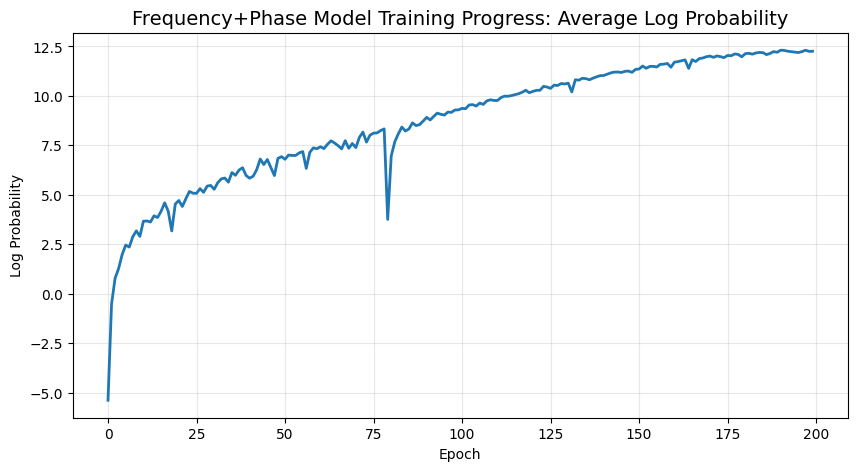

In [21]:
#Traning Progress
plt.figure(figsize=(10, 5))
plt.plot(losses, linewidth=2)
plt.title('Frequency+Phase Model Training Progress: Average Log Probability', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Log Probability')
plt.grid(True, alpha=0.3)
plt.show()

FOR VIEWING AMPLITUDE, FREQUENCY AND PHASE RESULTS

In [ ]:
from matplotlib.patches import Rectangle # Rectangle where both axes' 1-sigma regions overlap

# Test on several different true frequencies, phases, and amplitudes
test_frequencies = [1.0, 2.5, 4.0]
test_phases = [0.5, -0.3, 1.2]
test_amplitudes = [1.0, 0.8, 2.4]

fig, axes = plt.subplots(7, len(test_frequencies), figsize=(8*len(test_frequencies), 40))

print("Testing frequency+phase+amplitude model on new observations:\n")

for idx, true_freq in enumerate(test_frequencies):
    true_phase = test_phases[idx]
    true_amp = test_amplitudes[idx]
    print(f"\nTest {idx+1}: True Frequency = {true_freq}, True Phase = {true_phase:.2f}, True Amplitude = {true_amp:.2f}")
    
    # Generate new observation
    observed_data = simulate_sine_wave(true_freq, phase=true_phase, amplitude=true_amp)
    
    # Infer posterior
    posterior_samples, stats = infer_with_dingo(model, observed_data, num_samples=5000)
    # posterior_samples shape is [num_samples, 3] with [frequency, phase, amplitude]
    freq_samples = posterior_samples[:, 0]
    phase_samples = posterior_samples[:, 1]
    amp_samples = posterior_samples[:, 2]
    
    freq_stats = {
        'mean': np.mean(freq_samples),
        'median': np.median(freq_samples),
        'std': np.std(freq_samples),
        'q05': np.percentile(freq_samples, 5),
        'q95': np.percentile(freq_samples, 95),
    }
    
    phase_stats = {
        'mean': np.mean(phase_samples),
        'median': np.median(phase_samples),
        'std': np.std(phase_samples),
        'q05': np.percentile(phase_samples, 5),
        'q95': np.percentile(phase_samples, 95),
    }
    
    amp_stats = {
        'mean': np.mean(amp_samples),
        'median': np.median(amp_samples),
        'std': np.std(amp_samples),
        'q05': np.percentile(amp_samples, 5),
        'q95': np.percentile(amp_samples, 95),
    }
    
    parameters = ['frequency', 'phase', 'amplitude']
    ps = ['f', 'φ', 'A']
    samples_list = [freq_samples, phase_samples, amp_samples]
    stats_list = [freq_stats, phase_stats, amp_stats]
    true_list = [true_freq, true_phase, true_amp]

    print(f"  Frequency posterior: mean={freq_stats['mean']:.3f} ± {freq_stats['std']:.3f}")
    print(f"  Phase posterior:     mean={phase_stats['mean']:.3f} ± {phase_stats['std']:.3f}")
    print(f"  Amplitude posterior: mean={amp_stats['mean']:.3f} ± {amp_stats['std']:.3f}")
    
    t = np.linspace(0, 6*pi, 1000)

    # Plot observed data
    axes[0, idx].plot(t, observed_data, 'b-', alpha=0.7, linewidth=1.5, label='Observed')
    axes[0, idx].plot(t, true_amp * np.sin(2*pi*true_freq * t + true_phase), 'r--', 
                      label=f'True (f={true_freq}, φ={true_phase:.2f}, A={true_amp:.2f})', linewidth=2)
    axes[0, idx].set_title(f'Test {idx+1}: f={true_freq}, φ={true_phase:.2f}, A={true_amp:.2f}', fontsize=12, fontweight='bold')
    axes[0, idx].set_xlabel('Time')
    axes[0, idx].set_ylabel('Value')
    axes[0, idx].legend(fontsize=8)
    axes[0, idx].grid(True, alpha=0.3)

    for idx2, _ in enumerate(parameters):
        axes[idx2 + 1, idx].hist(samples_list[idx2], bins=60, density=True, 
                      alpha=0.6, edgecolor='black', label='Posterior')
        axes[idx2 + 1, idx].axvline(true_list[idx2], color='red', linestyle='--', 
                             linewidth=2.5, label=f'True: {true_list[idx2]:.2f}', zorder=10)
        axes[idx2 + 1, idx].axvline(stats_list[idx2]['mean'], color='green', linestyle='-', 
                             linewidth=2.5, label=f"Mean: {stats_list[idx2]['mean']:.2f}", zorder=10)
        axes[idx2 + 1, idx].axvspan(stats_list[idx2]['q05'], stats_list[idx2]['q95'], alpha=0.2, color='gray', label='90% CI')
        axes[idx2 + 1, idx].set_title(f'p({parameters[idx2]} | data)', fontsize=12, fontweight='bold')
        axes[idx2 + 1, idx].set_xlabel(parameters[idx2].capitalize())
        axes[idx2 + 1, idx].set_ylabel('Density')
        axes[idx2 + 1, idx].legend(loc='upper right', fontsize=8)
        axes[idx2 + 1, idx].grid(True, alpha=0.3)


    for idx2, _ in enumerate(parameters):
        # 2D histograms for frequency vs. phase 
        h = axes[len(parameters) + idx2 + 1, idx].hist2d(samples_list[idx2], samples_list[(idx2+1) % 3], bins=60, cmap='plasma', density=True)
        plt.colorbar(h[3], ax=axes[len(parameters) + idx2 + 1, idx], label='Probability Density')
        axes[len(parameters) + idx2 + 1, idx].scatter(true_list[idx2], true_list[(idx2+1) % 3], color='cyan', s=200, marker='x',  
                            edgecolors='white', linewidth=2, label='True values', zorder=10) # Plot true values
        axes[len(parameters) + idx2 + 1, idx].scatter(stats_list[idx2]['mean'], stats_list[(idx2+1) % 3]['mean'], color='lime', s=100, marker='o', 
                            linewidth=3, label='Posterior mean', zorder=10) # Plot mean

        rect = Rectangle((stats_list[idx2]['mean'] - stats_list[idx2]['std'], stats_list[(idx2+1) % 3]['mean'] - stats_list[(idx2+1) % 3]['std']), 
                        width=2*stats_list[idx2]['std'], height=2*stats_list[(idx2+1) % 3]['std'],
                        facecolor='yellow', edgecolor='yellow', linewidth=2, 
                        alpha=0.3, label='1σ region', zorder=5)
        
        axes[len(parameters) + idx2 + 1, idx].add_patch(rect)
        axes[len(parameters) + idx2 + 1, idx].set_xlabel(parameters[idx2], fontsize=12, fontweight='bold')
        axes[len(parameters) + idx2 + 1, idx].set_ylabel(parameters[(idx2+1) % 3], fontsize=12, fontweight='bold')
        axes[len(parameters) + idx2 + 1, idx].set_title(f'Joint Posterior p({ps[idx2]}, {ps[(idx2+1) % 3]} | data)\nTrue: {ps[idx2]}={true_list[idx2]}, {ps[(idx2+1) % 3]}={true_list[(idx2+1) % 3]}', fontsize=12, fontweight='bold')
        axes[len(parameters) + idx2 + 1, idx].legend(loc='upper right', fontsize=8)
        axes[len(parameters) + idx2 + 1, idx].grid(True, alpha=0.3)

    
plt.tight_layout()
plt.show()


FOR VIEWING FREQUENCY ONLY TESTS

TESTING VARIABLE-MODE FREQUENCY INFERENCE (1-5 Modes)

Note: Training used -1 as padding marker (meaning 'no frequency')
This prevents the model from thinking 0 is a valid frequency value

Testing variable-mode frequency model on new observations:


Test 1: 1-Mode Signal
True frequencies: [ 2. -1. -1. -1. -1.]
Active modes: 1

  Sample distribution:
    Negative samples (padding): 20000 / 25000 (80.0%)
    Positive samples (real):    5000 / 25000 (20.0%)

  Positive frequency statistics:
    Mean: 2.03
    Std Dev: 0.13
    Min: 1.78
    Max: 3.74

  Per-parameter summary:
    Freq 1 (ACTIVE ): True=2.00, Inferred=2.03±0.13, Error=0.0323
    Freq 2 (padded ): Inferred=-1.00±0.00 (should be negative)
    Freq 3 (padded ): Inferred=-1.00±0.01 (should be negative)
    Freq 4 (padded ): Inferred=-1.00±0.00 (should be negative)
    Freq 5 (padded ): Inferred=-1.00±0.00 (should be negative)

Test 2: 2-Mode Signal
True frequencies: [ 1.5  3.  -1.  -1.  -1. ]
Active modes: 2

  Sample distribu

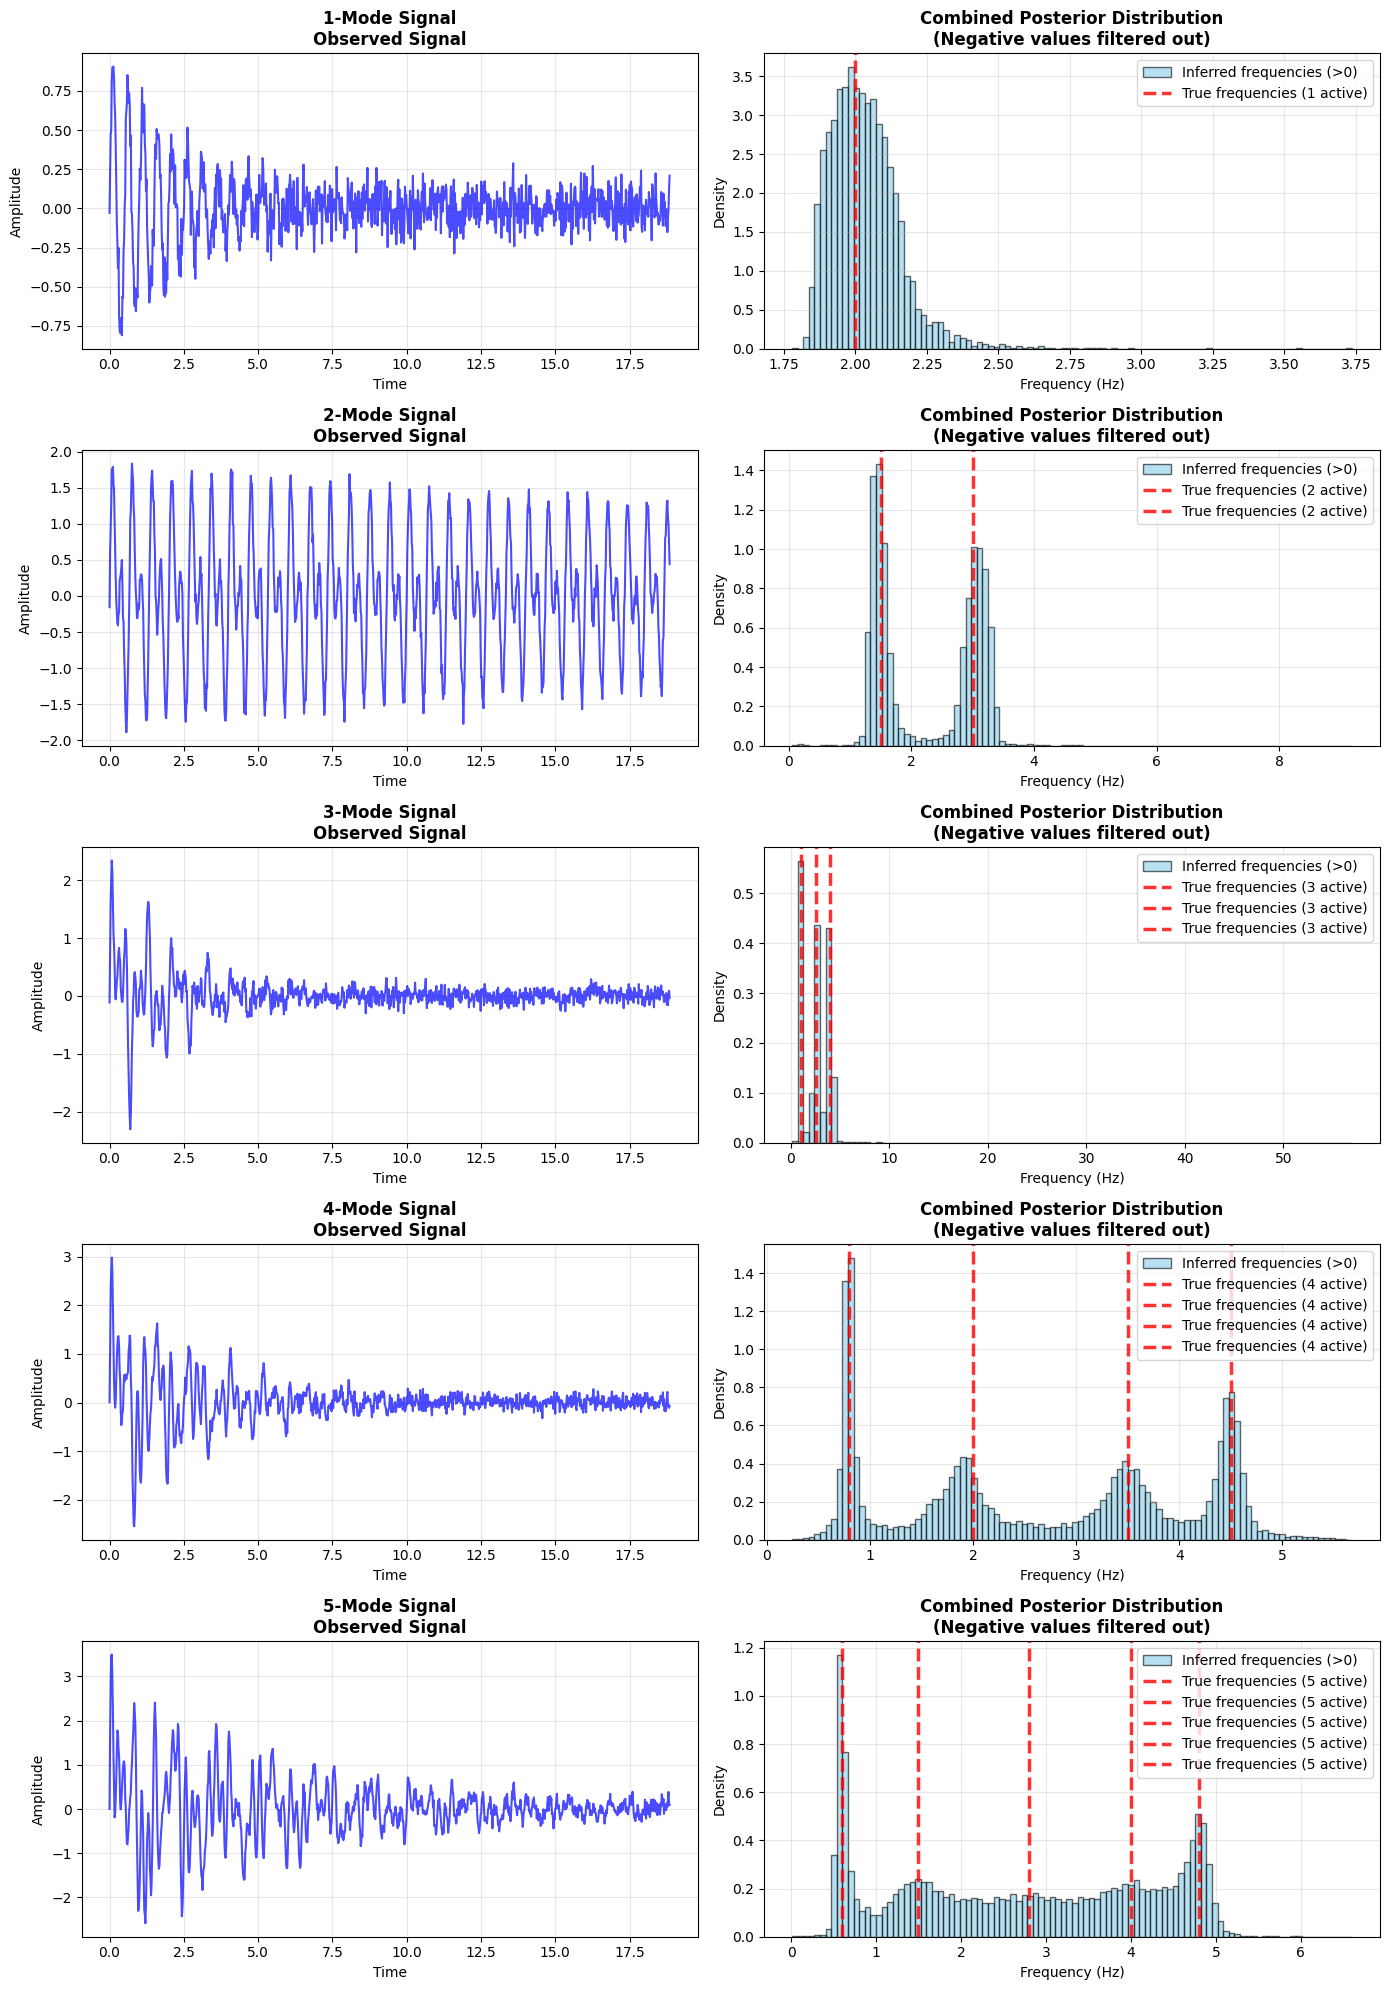


TESTING COMPLETE

Key observations:
✓ The histogram now shows only POSITIVE inferred frequencies
✓ Red dashed lines mark the true active frequencies
✓ Green line shows the mean of positive frequency samples
✓ Model should output negative values for absent modes (filtered out in histogram)
✓ This prevents spurious peaks at 0 - the model learns -1 means 'no frequency'


In [ ]:
print("="*80)
print("TESTING VARIABLE-MODE FREQUENCY INFERENCE (1-5 Modes)")
print("="*80)
print("\nNote: Training used -1 as padding marker (meaning 'no frequency')")
print("This prevents the model from thinking 0 is a valid frequency value")

# Test different numbers of active modes
# Note: Using -1 as padding marker (tells model "no frequency here")
test_cases = [
    {
        'name': '1-Mode Signal',
        'frequencies': [2.0, -1.0, -1.0, -1.0, -1.0],
        'num_samples': 5000
    },
    {
        'name': '2-Mode Signal',
        'frequencies': [1.5, 3.0, -1.0, -1.0, -1.0],
        'num_samples': 5000
    },
    {
        'name': '3-Mode Signal',
        'frequencies': [1.0, 2.5, 4.0, -1.0, -1.0],
        'num_samples': 5000
    },
    {
        'name': '4-Mode Signal',
        'frequencies': [0.8, 2.0, 3.5, 4.5, -1.0],
        'num_samples': 5000
    },
    {
        'name': '5-Mode Signal',
        'frequencies': [0.6, 1.5, 2.8, 4.0, 4.8],
        'num_samples': 5000
    }
]

fig, axes = plt.subplots(len(test_cases), 2, figsize=(14, 4*len(test_cases)))

print("\nTesting variable-mode frequency model on new observations:\n")

for test_idx, test_case in enumerate(test_cases):
    true_freqs = np.array(test_case['frequencies'])
    num_active = np.sum(true_freqs > 0)
    
    print(f"\n{'='*60}")
    print(f"Test {test_idx+1}: {test_case['name']}")
    print(f"True frequencies: {true_freqs}")
    print(f"Active modes: {num_active}")
    print(f"{'='*60}")
    
    # Generate signal from true frequencies
    observed_data = simulate_variable_multifreq_decaying_sine_wave(true_freqs, amp=1.0, phase=0.0, noise_std=0.1)
    
    # Infer posterior
    model.eval()
    with torch.no_grad():
        data_tensor = torch.FloatTensor(observed_data).unsqueeze(0)
        context = model.embedding_net(data_tensor)
        posterior_samples = model.flow.sample(context, num_samples=test_case['num_samples']).cpu().numpy()

    #posterior_samples, _ = infer_with_dingo(model, observed_data, num_samples=test_case['num_samples'])[0]

    # Plot 1: Observed signal
    t = np.linspace(0, 6*pi, 1000)
    axes[test_idx, 0].plot(t, observed_data, 'b-', alpha=0.7, linewidth=1.5)
    axes[test_idx, 0].set_title(f'{test_case["name"]}\nObserved Signal', fontsize=12, fontweight='bold')
    axes[test_idx, 0].set_xlabel('Time')
    axes[test_idx, 0].set_ylabel('Amplitude')
    axes[test_idx, 0].grid(True, alpha=0.3)
    
    # Plot 2: Combined histogram of all inferred frequencies
    # KEY FIX: Filter out negative samples (model's way of saying "no frequency here")
    ax = axes[test_idx, 1]
    
    # Collect all frequency samples and filter out negatives
    all_samples_raw = posterior_samples.flatten()
    all_samples = all_samples_raw[all_samples_raw > 0]  # Only keep positive frequencies
    
    # Plot histogram
    ax.hist(all_samples, bins=100, density=True, alpha=0.6, edgecolor='black', color='skyblue', label='Inferred frequencies (>0)')
    
    # Mark true frequencies as vertical lines
    for freq_idx, true_val in enumerate(true_freqs):
        if true_val > 0:
            ax.axvline(true_val, color='red', linestyle='--', linewidth=2.5, alpha=0.8, label=f'True frequencies ({num_active} active)')
    
    ax.set_title(f'Combined Posterior Distribution\n(Negative values filtered out)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Density')
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Print summary statistics
    num_negatives = np.sum(all_samples_raw < 0)
    num_positives = np.sum(all_samples_raw > 0)
    
    print(f"\n  Sample distribution:")
    print(f"    Negative samples (padding): {num_negatives} / {len(all_samples_raw)} ({100*num_negatives/len(all_samples_raw):.1f}%)")
    print(f"    Positive samples (real):    {num_positives} / {len(all_samples_raw)} ({100*num_positives/len(all_samples_raw):.1f}%)")
    
    if len(all_samples) > 0:
        print(f"\n  Positive frequency statistics:")
        print(f"    Mean: {np.mean(all_samples):.2f}")
        print(f"    Std Dev: {np.std(all_samples):.2f}")
        print(f"    Min: {np.min(all_samples):.2f}")
        print(f"    Max: {np.max(all_samples):.2f}")
    
    # Per-parameter summary
    print(f"\n  Per-parameter summary:")
    for param_idx in range(5):
        param_samples = posterior_samples[:, param_idx]
        param_mean = np.mean(param_samples)
        param_std = np.std(param_samples)
        true_val = true_freqs[param_idx]
        status = 'ACTIVE' if true_val > 0 else 'padded'
        
        if true_val > 0:
            error = abs(param_mean - true_val)
            print(f"    Freq {param_idx+1} ({status:7s}): True={true_val:.2f}, Inferred={param_mean:.2f}±{param_std:.2f}, Error={error:.4f}")
        else:
            print(f"    Freq {param_idx+1} ({status:7s}): Inferred={param_mean:.2f}±{param_std:.2f} (should be negative)")

plt.tight_layout()
plt.show()